In [56]:
# uses conda environment gpflow6_0

# #!/anaconda3/envs/gpflow6_0/env/bin/python

from memory_profiler import profile

# generic
import numpy as np
import pandas as pd
import xarray as xr
# import dask.array as da
import scipy.io as io
from itertools import product
import glob
import time
import os

# plotting
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
import seaborn as sns

# gpflow
import gpflow as gpf
from gpflow.utilities import print_summary
from gpflow.logdensities import multivariate_normal
from gpflow.kernels import Kernel
from gpflow.mean_functions import MeanFunction
from typing import Optional, Tuple, List
from gpflow.config import default_jitter

# tensorflow
import tensorflow as tf
from tensorflow_probability import bijectors as tfb
import argparse


# set the colormap and centre the colorbar
class MidpointNormalize(Normalize):
    """Normalise the colorbar.  e.g. norm=MidpointNormalize(mymin, mymax, 0.)"""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


####################  Initialize parameters #######################
#################### ---------------------- #######################

# parser = argparse.ArgumentParser(description='import vars via c-line')
# parser.add_argument("--mod", default='d6g_h6g_')
# parser.add_argument("--lith", default='l71C')
# parser.add_argument("--um", default="p2")
# parser.add_argument("--lm", default="3")
# parser.add_argument("--tmax", default="4010")
# parser.add_argument("--tmin", default="2990")
# parser.add_argument("--place", default="fennoscandia")

# args = parser.parse_args()
# ice_models = [args.mod]
# lith_thicknesses = [args.lith]
# um = args.um
# lm = args.lm
# tmax = int(args.tmax)
# tmin = int(args.tmin)
# place = args.place

ice_models =  ['glac1d_']#['d6g_h6g_'] # 
lith_thicknesses = ['l71C']
um = 'p2'
lm = '3'
tmax = '12010'
tmin = '1950'
place = 'europe'

for i, ice_model in enumerate(ice_models):
    for k, lith_thickness in enumerate(lith_thicknesses):
        plotting = 'true'
        decomp = 'false'
        ice_model = ice_model 
        lith_thickness = lith_thickness 
        model = ice_model + lith_thickness
        place = place
        mantle = f'um{um}_lm{lm}'

        locs = {
            'england': [-12, 2, 50, 60],
            'easternhem': [50, 178, -45, 80],
            'westernhem': [-175, 30, -80, 75],
            'world': [-179.8, 179.8, -89.8, 89.8],
            'namerica': [-150, -20, 10, 75],
            'eastcoast': [-88, -65, 15, 40],
            'europe': [-20, 15, 35, 70],
            'atlantic':[-85,50, 25, 73],
            'fennoscandia': [-15, 52, 45, 75],
        }
        extent = locs[place]
        tmax, tmin, tstep = int(tmax), int(tmin), 100

        ages_lgm = np.arange(100, 26000, tstep)[::-1]

        #import khan dataset
        path = 'data/GSL_LGM_120519_.csv'

        df = pd.read_csv(path, encoding="ISO-8859-15", engine='python')
        df = df.replace('\s+', '_', regex=True).replace('-', '_', regex=True).\
                applymap(lambda s:s.lower() if type(s) == str else s)
        df.columns = df.columns.str.lower()
        df.rename_axis('index', inplace=True)
        df = df.rename({'latitude': 'lat', 'longitude': 'lon'}, axis='columns')
        dfind, dfterr, dfmar = df[(df.type == 0)
                                  & (df.age > 0)], df[df.type == 1], df[df.type == -1]
        np.sort(list(set(dfind.regionname1)))

        #select location
        df_place = dfind[(dfind.age > tmin) & (dfind.age < tmax) &
                         (dfind.lon > extent[0])
                         & (dfind.lon < extent[1])
                         & (dfind.lat > extent[2])
                         & (dfind.lat < extent[3])][[
                             'lat', 'lon', 'rsl', 'rsl_er_max', 'age'
                         ]]
        preslocs = df_place.groupby(['lat', 'lon'])[['rsl', 'rsl_er_max', 'age']].nunique().reset_index()[::2]  
        preslocs['rsl'] = 0
        preslocs['rsl_er_max'] = 0
        preslocs['age'] = 0
        df_place = pd.concat([df_place, preslocs]).reset_index(drop=True)

df_place.shape

(2239, 5)

In [57]:
df_place

,lat,lon,rsl,rsl_er_max,age
0,43.32,-2.68,-2.512,0.557,1961
1,50.76,2.27,-1.828,3.316,1964
2,43.28,-8.22,-1.804,2.092,1965
3,46.54,-1.81,0.030,3.175,1966
4,50.56,1.59,-0.263,4.817,2122
...,...,...,...,...,...
2234,58.45,-3.13,0.000,0.000,0
2235,58.45,-3.11,0.000,0.000,0
2236,58.47,-4.71,0.000,0.000,0
2237,58.97,-2.97,0.000,0.000,0


---------------
glac1d_l71C_ump2_lm3 run number 0
number of datapoints =  (2342, 8)


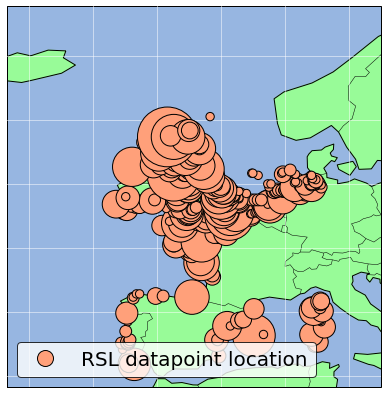

In [180]:
####################  	Plot locations  	#######################
#################### ---------------------- #######################

#get counts by location rounded to nearest 0.1 degree
if plotting == 'true':
    df_rnd = df_place.copy()
    df_rnd.lat = np.round(df_rnd.lat, 1)
    df_rnd.lon = np.round(df_rnd.lon, 1)
    dfcounts_place = df_rnd.groupby(
        ['lat', 'lon']).count().reset_index()[['lat', 'lon', 'rsl', 'age']]

    #plot
    fig = plt.figure(figsize=(10, 7))
    ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())

    ax.set_extent(extent)
    ax.coastlines(resolution='110m', linewidth=1, zorder=2)
    ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.add_feature(cfeature.LAND, color='palegreen', zorder=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=3)
    ax.gridlines(linewidth=1, color='white', alpha=0.5, zorder=4)
    scat = ax.scatter(dfcounts_place.lon,
                      dfcounts_place.lat,
                      s=dfcounts_place.rsl * 70,
                      c='lightsalmon',
                      vmin=-20,
                      vmax=20,
                      cmap='coolwarm',
                      edgecolor='k',
                      linewidths=1,
                      transform=ccrs.PlateCarree(),
                      zorder=5)
    size = Line2D(range(4),
                  range(4),
                  color="black",
                  marker='o',
                  linewidth=0,
                  linestyle='none',
                  markersize=16,
                  markerfacecolor="lightsalmon")
    labels = ['RSL datapoint location']
    leg = plt.legend([size],
                     labels,
                     loc='lower left',
                     bbox_to_anchor=(0.00, 0.00),
                     prop={'size': 20},
                     fancybox=True)
    leg.get_frame().set_edgecolor('k')
    ax.set_title('')

####################  Make 3D fingerprint  #######################
#################### ---------------------- #######################

filename = 'data/WAISreadvance_VM5_6ka_1step.mat'

waismask = io.loadmat(filename, squeeze_me=True)
ds_mask = xr.Dataset({'rsl': (['lat', 'lon', 'age'], waismask['RSL'])},
                     coords={
                         'lon': waismask['lon_out'],
                         'lat': waismask['lat_out'],
                         'age': np.round(waismask['ice_time_new'])
                     })
fingerprint = ds_mask.sel(age=ds_mask.age[0])


def make_fingerprint(start, end, maxscale):

    #palindromic scaling vector
    def palindrome(maxscale, ages):
        """ Make palindrome scale 0-maxval with number of steps. """
        half = np.linspace(0, maxscale, 1 + (len(ages) - 1) // 2)
        scalefactor = np.concatenate([half, half[::-1]])
        return scalefactor

    ages_readv = ages_lgm[(ages_lgm < start) & (ages_lgm >= end)]
    scale = palindrome(maxscale, ages_readv)

    #scale factor same size as ice model ages
    pre = np.zeros(np.where(ages_lgm == start)[0])
    post = np.zeros(len(ages_lgm) - len(pre) - len(scale))

    readv_scale = np.concatenate([pre, scale, post])

    #scale factor into dataarray
    da_scale = xr.DataArray(readv_scale, coords=[('age', ages_lgm)])

    # broadcast fingerprint & scale to same dimensions;
    fingerprint_out, fing_scaled = xr.broadcast(fingerprint.rsl, da_scale)

    # mask fingerprint with scale to get LGM-pres timeseries
    ds_fingerprint = (fingerprint_out *
                      fing_scaled).transpose().to_dataset(name='rsl')

    # scale dataset with fingerprint to LGM-present length & 0-max-0 over x years
    xrlist = []
    for i, key in enumerate(da_scale):
        mask = ds_fingerprint.sel(age=ds_fingerprint.age[i].values) * key
        mask = mask.assign_coords(scale=key,
                                  age=ages_lgm[i]).expand_dims(dim=['age'])
        xrlist.append(mask)
    ds_readv = xr.concat(xrlist, dim='age')

    ds_readv.coords['lon'] = pd.DataFrame((ds_readv.lon[ds_readv.lon >= 180] - 360)- 0.12) \
                            .append(pd.DataFrame(ds_readv.lon[ds_readv.lon < 180]) + 0.58) \
                            .reset_index(drop=True).squeeze()
    ds_readv = ds_readv.swap_dims({'dim_0': 'lon'}).drop('dim_0')

    # Add readv to modeled RSL at locations with data
    ##### Need to fix this, as currently slice does not acknowledge new coords #########
    ds_readv = ds_readv.sel(age=slice(tmax, tmin),
                            lon=slice(df_place.lon.min() + 180 - 2,
                                      df_place.lon.max() + 180 + 2),
                            lat=slice(df_place.lat.max() + 2,
                                      df_place.lat.min() - 2))
    return ds_readv


#Make deterministic readvance fingerprint
start, end = 6100, 3000
maxscale = 2.25
ds_readv = make_fingerprint(start, end, maxscale)


####################  Build  GIA models 	#######################
#################### ---------------------- #######################

#Use either glac1d or ICE6G


def build_dataset(path, model):
    """download model runs from local directory."""
    path = path
    files = f'{path}*.nc'
    basefiles = glob.glob(files)
    modelrun = [
        key.split('output_', 1)[1][:-3].replace('.', '_')
        for key in basefiles
    ]
    dss = xr.open_mfdataset(files,
                            chunks=None,
                            concat_dim='modelrun',
                            combine='nested')
    lats, lons, times = dss.LAT.values[0], dss.LON.values[
        0], dss.TIME.values[0]
    ds = dss.drop(['LAT', 'LON', 'TIME'])
    ds = ds.assign_coords(lat=lats,
                          lon=lons,
                          time=times,
                          modelrun=modelrun).rename({
                              'time': 'age',
                              'RSL': 'rsl'
                          })
    return ds

def one_mod(path, names):
    """Organize model runs into xarray dataset."""
    ds1 = build_dataset(path, names[0])
    names = names[1:]
    ds = ds1.chunk({'lat': 10, 'lon': 10})
    for i in range(len(names)):
        temp = build_dataset(names[i])
        temp1 = temp.interp_like(ds1)
        temp1['modelrun'] = temp['modelrun']
        ds = xr.concat([ds, temp1], dim='modelrun')
    ds['age'] = ds['age'] * 1000
    ds = ds.roll(lon=256, roll_coords=True)
    ds.coords['lon'] = pd.DataFrame((ds.lon[ds.lon >= 180] - 360)- 0.12 ) \
                            .append(pd.DataFrame(ds.lon[ds.lon < 180]) + 0.58) \
                            .reset_index(drop=True).squeeze()
    ds.coords['lat'] = ds.lat[::-1]
    ds = ds.swap_dims({'dim_0': 'lon'}).drop('dim_0')
    return ds

#make composite of a bunch of GIA runs, i.e. GIA prior

if ice_model == 'glac1d_':
    path = f'data/glac1d_/output_{model}'

    #make composite of a bunch of GIA runs, i.e. GIA prior
    ds = one_mod(path, [model])
    ds_sliced = ds.rsl.sel(age=slice(tmax, tmin),
                           lon=slice(df_place.lon.min() - 2,
                                     df_place.lon.max() + 2),
                           lat=slice(df_place.lat.min() - 2,
                                     df_place.lat.max() + 2))

elif ice_model == 'd6g_h6g_':
    path = f'data/d6g_h6g_/output_{model}'

    #make GIA prior std.
    ds = one_mod(path, [model])
    ds_sliced = ds.rsl.sel(age=slice(tmax, tmin),
                           lon=slice(df_place.lon.min() - 2,
                                     df_place.lon.max() + 2),
                           lat=slice(df_place.lat.min() - 2,
                                     df_place.lat.max() + 2))

ds_areastd = ds_sliced.std(dim='modelrun').load().to_dataset().interp(
    age=ds_readv.age, lon=ds_readv.lon, lat=ds_readv.lat)

# loop through all models to calculate GPR log likelihood
# runs = ds.modelrun.values.tolist()
runs = [f'{ice_model}{lith_thickness}_um{um}_lm{lm}']

modrunlist = []
loglikelist = []
for i, modelrun in enumerate(runs):

    print('---------------')
    print(f'{modelrun} run number {i}')

    if ice_model == 'glac1d_':
        # make prior RSL        
        ds_area = one_mod(path, [ice_model + lith_thickness]).sel(modelrun=modelrun).rsl.sel(
                                            age=slice(tmax, tmin),
                                            lon=slice(df_place.lon.min() - 2,
                                                      df_place.lon.max() + 2),
                                            lat=slice(df_place.lat.min() - 2,
                                                      df_place.lat.max() + 2)).load().to_dataset().interp(
                                            age=ds_readv.age, lon=ds_readv.lon, lat=ds_readv.lat)

    else:
        # make prior RSL
        ds_area = one_mod(path, [ice_model + lith_thickness]).sel(modelrun=modelrun).rsl
        ds_area = ds_area.assign_coords({'lat':ds_area.lat.values[::-1]}).sel(
                                            age=slice(tmax, tmin),
                                            lon=slice(df_place.lon.min() - 2,
                                                      df_place.lon.max() + 2),
                                            lat=slice(df_place.lat.max() + 2,
                                                      df_place.lat.min() - 2)).load().to_dataset().interp(
                                            age=ds_readv.age, lon=ds_readv.lon, lat=ds_readv.lat)


    #sample each model at points where we have RSL data
    def ds_select(ds):
        return ds.rsl.sel(age=[row.age],
                          lon=[row.lon],
                          lat=[row.lat],
                          method='nearest').squeeze().values

    #select points at which RSL data exists
    for i, row in df_place.iterrows():
        df_place.loc[i, 'rsl_realresid'] = df_place.rsl[i] - ds_select(ds_area)
        df_place.loc[i, 'rsl_giaprior'] = ds_select(ds_area)
        df_place.loc[i, 'rsl_giaprior_std'] = ds_select(ds_areastd)

    print('number of datapoints = ', df_place.shape)

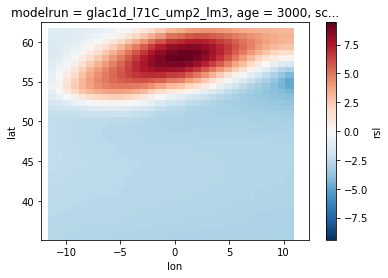

In [190]:
ds_area.rsl[90].transpose().plot()

model built, time= 0.023354768753051758
model minimized, time= 19.123823165893555


name,class,transform,prior,trainable,shape,dtype,value
GPR_diag.kernel.kernels[0].kernels[0].variance,Parameter,Sigmoid + AffineScalar,,True,(),float64,0.13307476680523378
GPR_diag.kernel.kernels[0].kernels[0].lengthscale,Parameter,Sigmoid + AffineScalar,,True,(),float64,29067.792147154996
GPR_diag.kernel.kernels[0].kernels[1].variance,Parameter,Sigmoid + AffineScalar,,True,(),float64,0.5943646564707609
GPR_diag.kernel.kernels[0].kernels[1].lengthscale,Parameter,Sigmoid + AffineScalar,,True,(),float64,8002.085312455155
GPR_diag.kernel.kernels[1].kernels[0].variance,Parameter,Sigmoid + AffineScalar,,True,(),float64,9.1769558565216
GPR_diag.kernel.kernels[1].kernels[0].lengthscale,Parameter,Sigmoid + AffineScalar,,True,(),float64,1150.9108492067037
GPR_diag.kernel.kernels[1].kernels[1].variance,Parameter,Sigmoid + AffineScalar,,True,(),float64,0.4226665798922464
GPR_diag.kernel.kernels[1].kernels[1].lengthscale,Parameter,Sigmoid + AffineScalar,,True,(),float64,8000.0
GPR_diag.kernel.kernels[2].variance,Parameter,Sigmoid + AffineScalar,,True,(),float64,0.009999999776482582
GPR_diag.likelihood.variance,Parameter,Softplus + Shift,,True,"(266,)",float64,"[5.20146202e-01, 2.24308762e+01, 2.15857256e-06..."


time elapsed =  23.09020209312439
negative log marginal likelihood = -98.03954923694857


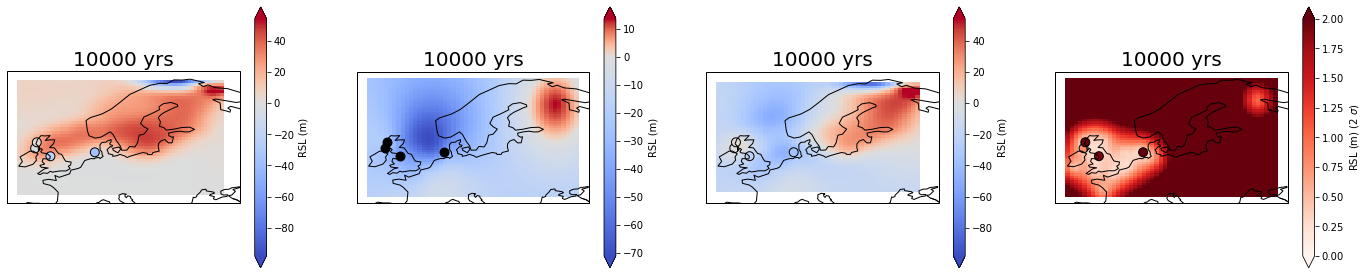

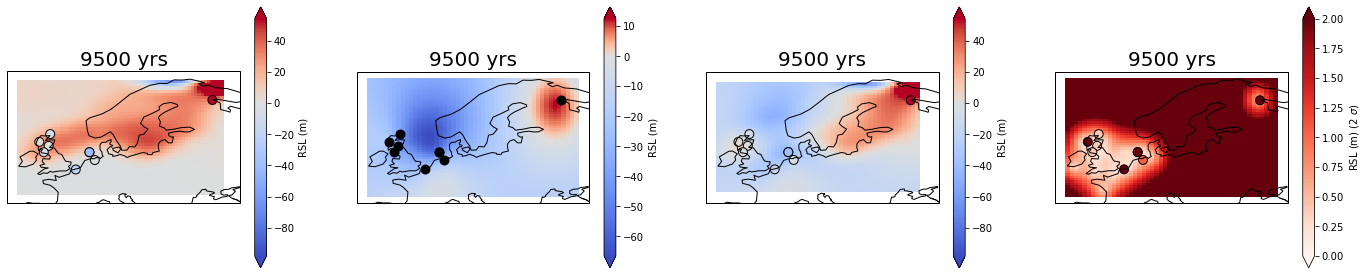

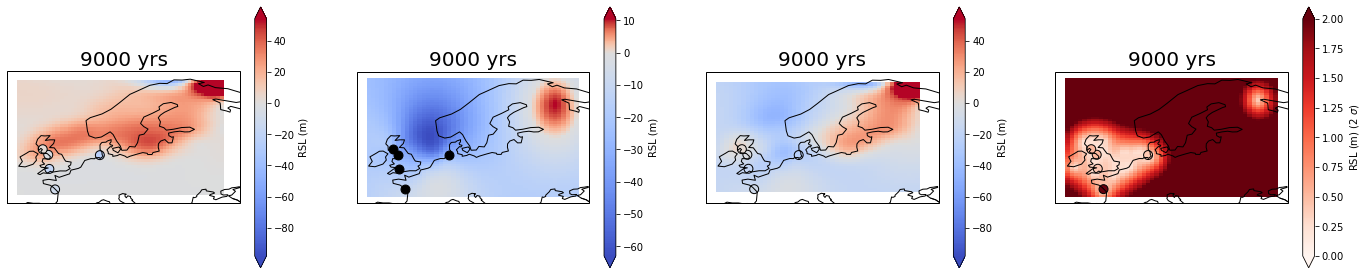

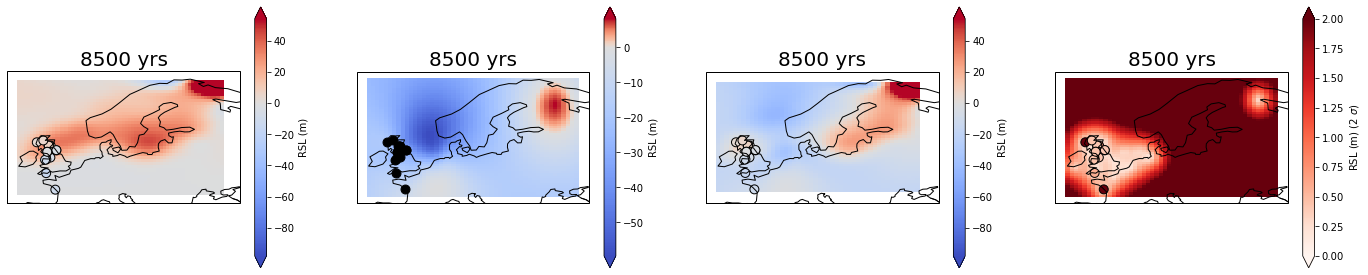

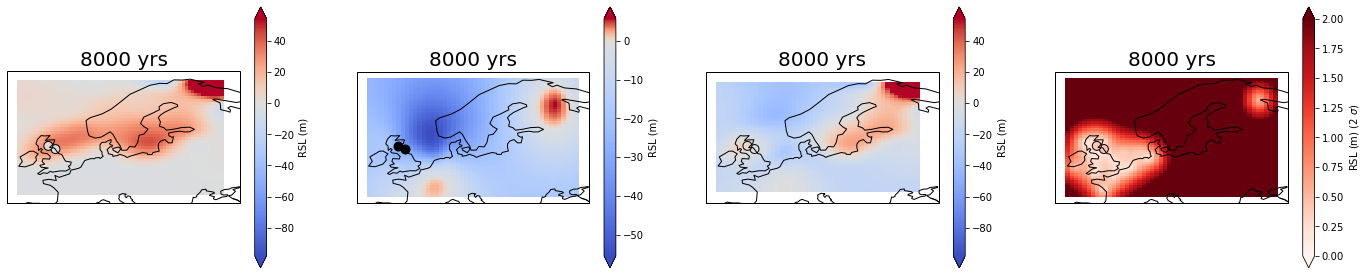

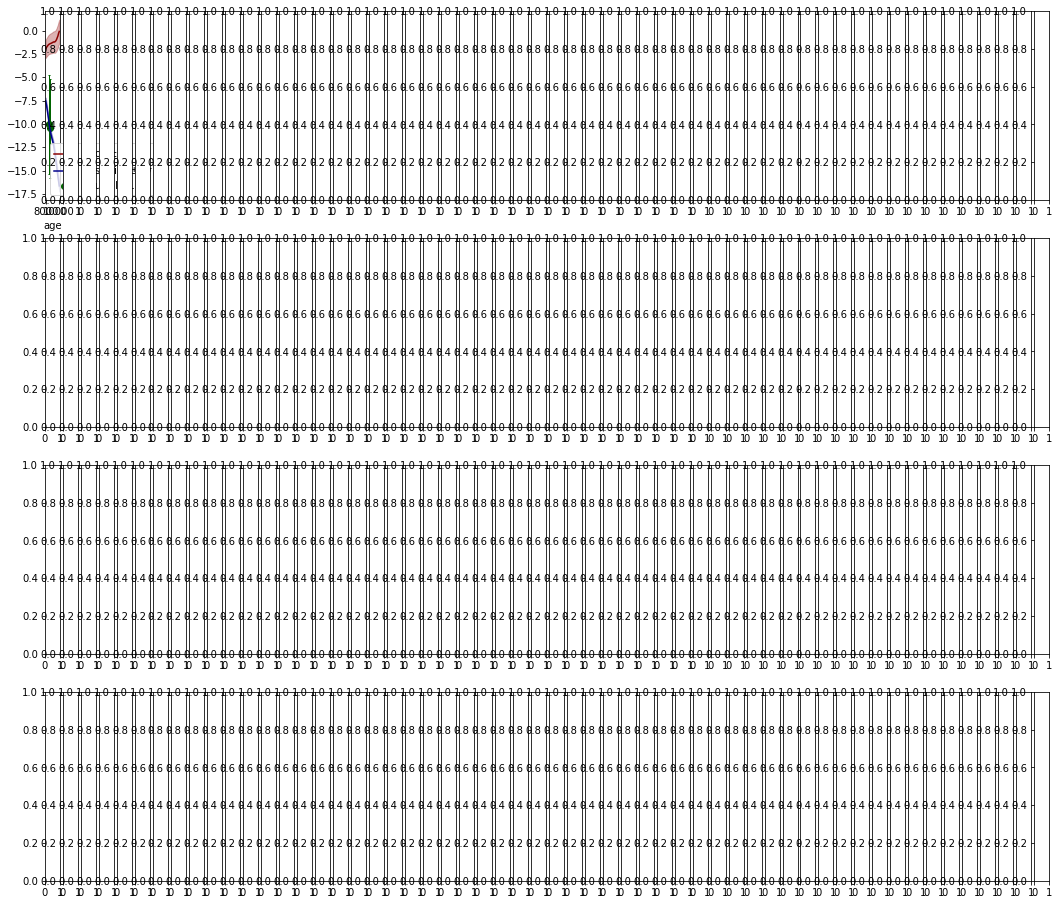

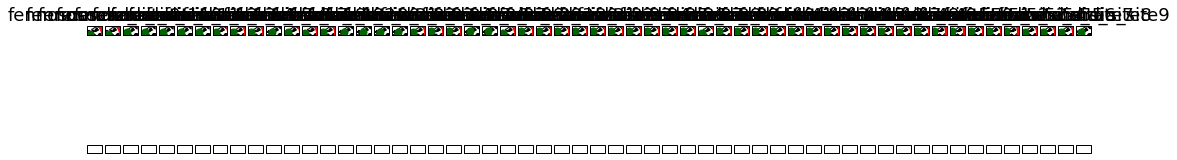

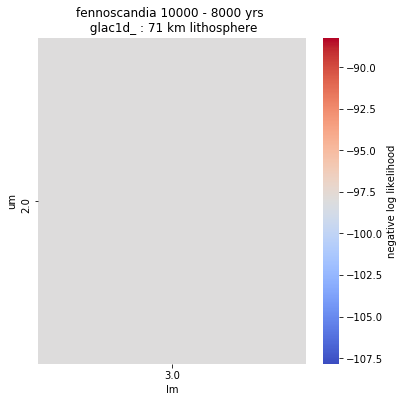

In [171]:
    ##################	  RUN GP REGRESSION 	#######################
    ##################  --------------------	 ######################
    start = time.time()

    def run_gpr():

        Data = Tuple[tf.Tensor, tf.Tensor]
        likelihood = df_place.rsl_er_max.ravel()**2 # + df_place.rsl_giaprior_std.ravel()**2  # here we define likelihood

        class GPR_diag(gpf.models.GPModel):
            r"""
            Gaussian Process Regression.
            This is a vanilla implementation of GP regression with a pointwise Gaussian
            likelihood.  Multiple columns of Y are treated independently.
            The log likelihood of this models is sometimes referred to as the 'marginal log likelihood',
            and is given by
            .. math::
               \log p(\mathbf y \,|\, \mathbf f) =
                    \mathcal N\left(\mathbf y\,|\, 0, \mathbf K + \sigma_n \mathbf I\right)
            """
            def __init__(self,
                         data: Data,
                         kernel: Kernel,
                         mean_function: Optional[MeanFunction] = None,
                         likelihood=likelihood):
                likelihood = gpf.likelihoods.Gaussian(variance=likelihood)
                _, y_data = data
                super().__init__(kernel,
                                 likelihood,
                                 mean_function,
                                 num_latent=y_data.shape[-1])
                self.data = data

            def log_likelihood(self):
                """
                Computes the log likelihood.
                """
                x, y = self.data
                K = self.kernel(x)
                num_data = x.shape[0]
                k_diag = tf.linalg.diag_part(K)
                s_diag = tf.convert_to_tensor(self.likelihood.variance)
                jitter = tf.cast(tf.fill([num_data], default_jitter()),
                                 'float64')  # stabilize K matrix w/jitter
                ks = tf.linalg.set_diag(K, k_diag + s_diag + jitter)
                L = tf.linalg.cholesky(ks)
                m = self.mean_function(x)

                # [R,] log-likelihoods for each independent dimension of Y
                log_prob = multivariate_normal(y, m, L)
                return tf.reduce_sum(log_prob)

            def predict_f(self,
                          predict_at: tf.Tensor,
                          full_cov: bool = False,
                          full_output_cov: bool = False):
                r"""
                This method computes predictions at X \in R^{N \x D} input points
                .. math::
                    p(F* | Y)
                where F* are points on the GP at new data points, Y are noisy observations at training data points.
                """
                x_data, y_data = self.data
                err = y_data - self.mean_function(x_data)

                kmm = self.kernel(x_data)
                knn = self.kernel(predict_at, full=full_cov)
                kmn = self.kernel(x_data, predict_at)

                num_data = x_data.shape[0]
                s = tf.linalg.diag(tf.convert_to_tensor(
                    self.likelihood.variance))  #changed from normal GPR

                conditional = gpf.conditionals.base_conditional
                f_mean_zero, f_var = conditional(
                    kmn, kmm + s, knn, err, full_cov=full_cov,
                    white=False)  # [N, P], [N, P] or [P, N, N]
                f_mean = f_mean_zero + self.mean_function(predict_at)
                return f_mean, f_var


        def normalize(df):
            return np.array((df - df.mean()) / df.std()).reshape(len(df), 1)


        def denormalize(y_pred, df):
            return np.array((y_pred * df.std()) + df.mean())


        def bounded_parameter(low, high, param):
            """Make parameter tfp Parameter with optimization bounds."""
            affine = tfb.AffineScalar(shift=tf.cast(low, tf.float64),
                                      scale=tf.cast(high - low, tf.float64))
            sigmoid = tfb.Sigmoid()
            logistic = tfb.Chain([affine, sigmoid])
            parameter = gpf.Parameter(param, transform=logistic, dtype=tf.float64)
            return parameter


        class HaversineKernel_Matern52(gpf.kernels.Matern52):
            """
            Isotropic Matern52 Kernel with Haversine distance instead of euclidean distance.
            Assumes n dimensional data, with columns [latitude, longitude] in degrees.
            """
            def __init__(
                self,
                lengthscale=1.0,
                variance=1.0,
                active_dims=None,
            ):
                super().__init__(
                    active_dims=active_dims,
                    variance=variance,
                    lengthscale=lengthscale,
                )

            def haversine_dist(self, X, X2):
                pi = np.pi / 180
                f = tf.expand_dims(X * pi, -2)  # ... x N x 1 x D
                f2 = tf.expand_dims(X2 * pi, -3)  # ... x 1 x M x D
                d = tf.sin((f - f2) / 2)**2
                lat1, lat2 = tf.expand_dims(X[:, 0] * pi, -1), \
                            tf.expand_dims(X2[:, 0] * pi, -2)
                cos_prod = tf.cos(lat2) * tf.cos(lat1)
                a = d[:, :, 0] + cos_prod * d[:, :, 1]
                c = tf.asin(tf.sqrt(a)) * 6371 * 2
                return c

            def scaled_squared_euclid_dist(self, X, X2):
                """
                Returns (dist(X, X2ᵀ)/lengthscales)².
                """
                if X2 is None:
                    X2 = X
                dist = da.square(self.haversine_dist(X, X2) / self.lengthscale)
        #             dist = tf.convert_to_tensor(dist)
                return dist


        class HaversineKernel_Matern32(gpf.kernels.Matern32):
            """
            Isotropic Matern52 Kernel with Haversine distance instead of euclidean distance.
            Assumes n dimensional data, with columns [latitude, longitude] in degrees.
            """
            def __init__(
                self,
                lengthscale=1.0,
                variance=1.0,
                active_dims=None,
            ):
                super().__init__(
                    active_dims=active_dims,
                    variance=variance,
                    lengthscale=lengthscale,
                )

            def haversine_dist(self, X, X2):
                pi = np.pi / 180
                f = tf.expand_dims(X * pi, -2)  # ... x N x 1 x D
                f2 = tf.expand_dims(X2 * pi, -3)  # ... x 1 x M x D
                d = tf.sin((f - f2) / 2)**2
                lat1, lat2 = tf.expand_dims(X[:, 0] * pi, -1), \
                            tf.expand_dims(X2[:, 0] * pi, -2)
                cos_prod = tf.cos(lat2) * tf.cos(lat1)
                a = d[:, :, 0] + cos_prod * d[:, :, 1]
                c = tf.asin(tf.sqrt(a)) * 6371 * 2
                return c

            def scaled_squared_euclid_dist(self, X, X2):
                """
                Returns (dist(X, X2ᵀ)/lengthscales)².
                """
                if X2 is None:
                    X2 = X
                dist = tf.square(self.haversine_dist(X, X2) / self.lengthscale)
        #             dist = tf.convert_to_tensor(dist) # return to tensorflow
                return dist


        ########### Section to Run GPR######################
        ##################################3#################

        # Input space, rsl normalized to zero mean, unit variance
        X = np.stack((df_place['lon'], df_place['lat'], df_place['age']), 1)
        RSL = normalize(df_place.rsl_realresid)

        #define kernels  with bounds

        k1 = HaversineKernel_Matern32(active_dims=[0, 1])
        k1.lengthscale = bounded_parameter(6000, 30000, 10000)  #hemispheric space
        k1.variance = bounded_parameter(0.1, 100, 2)

        # k1 = gpf.kernels.Matern32(active_dims=[0, 1])
        # k1.lengthscale = bounded_parameter(50, 500, 60)  #hemispheric space
        # k1.variance = bounded_parameter(0.05, 100, 2)

        k2 = HaversineKernel_Matern32(active_dims=[0, 1])
        k2.lengthscale = bounded_parameter(1, 6000, 1000)  #GIA space
        k2.variance = bounded_parameter(0.1, 100, 2)

        # k2 = gpf.kernels.Matern32(active_dims=[0,1])
        # k2.lengthscale = bounded_parameter(1, 50, 5)  #GIA space
        # k2.variance = bounded_parameter(0.05, 100, 2)

        k3 = gpf.kernels.Matern32(active_dims=[2])  #GIA time
        k3.lengthscale = bounded_parameter(8000, 20000, 10000)
        k3.variance = bounded_parameter(0.1, 100, 1)

        k4 = gpf.kernels.Matern32(active_dims=[2])  #shorter time
        k4.lengthscale = bounded_parameter(1, 8000, 1000)
        k4.variance = bounded_parameter(0.1, 100, 1)

        k5 = gpf.kernels.White(active_dims=[2])
        k5.variance = bounded_parameter(0.01, 100, 1)

        kernel = (k1 * k3) + (k2 * k4) + k5

        #build & train model
        m = GPR_diag((X, RSL), kernel=kernel, likelihood=likelihood)
        print('model built, time=', time.time() - start)


        @tf.function(autograph=False)
        def objective():
            return - m.log_marginal_likelihood()

        o = gpf.optimizers.Scipy()
        o.minimize(objective, variables=m.trainable_variables)
        print('model minimized, time=', time.time() - start)

        # output space
        nout = 50
        lat = np.linspace(min(ds_area.lat), max(ds_area.lat), nout)
        lon = np.linspace(min(ds_area.lon), max(ds_area.lon), nout)
        ages = ages_lgm[(ages_lgm < tmax) & (ages_lgm > tmin)]
        xyt = np.array(list(product(lon, lat, ages)))

        #query model & renormalize data
        y_pred, var = m.predict_f(xyt)
        y_pred_out = denormalize(y_pred, df_place.rsl_realresid)

        #reshape output vectors
#                    Xlon = np.array(xyt[:, 0]).reshape((nout, nout, len(ages)))
#                   Xlat = np.array(xyt[:, 1]).reshape((nout, nout, len(ages)))
        Zp = np.array(y_pred_out).reshape(nout, nout, len(ages))
        varp = np.array(var).reshape(nout, nout, len(ages))

        #print kernel details
        print_summary(m, fmt='notebook')
        print('time elapsed = ', time.time() - start)

        print('negative log marginal likelihood =',
              m.neg_log_marginal_likelihood().numpy())


        modrunlist.append(modelrun)
        loglikelist.append(m.neg_log_marginal_likelihood().numpy())



        ##################	  INTERPOLATE MODELS 	#######################
        ##################  --------------------	 ######################

        # turn GPR output into xarray dataarray
        da_zp = xr.DataArray(Zp, coords=[lon, lat, ages],
                             dims=['lon', 'lat',
                                   'age']).transpose('age', 'lat', 'lon')
        da_varp = xr.DataArray(varp,
                               coords=[lon, lat, ages],
                               dims=['lon', 'lat',
                                     'age']).transpose('age', 'lat', 'lon')


        def interp_likegpr(ds):
            return ds.rsl.load().transpose().interp_like(da_zp)


        #interpolate all models onto GPR grid
        da_giapriorinterp = interp_likegpr(ds_area)
        ds_giapriorinterp = ds_area.interp(age=ages)
        da_giapriorinterpstd = interp_likegpr(ds_areastd)

        # add total prior RSL back into GPR
        da_priorplusgpr = da_zp + da_giapriorinterp

        return k1, k2, k3, k4, k5, nout, xyt, m, ages, da_zp, ds_giapriorinterp, da_giapriorinterpstd, da_giapriorinterp, da_priorplusgpr, da_varp, modrunlist, loglikelist

    k1, k2, k3, k4, k5, nout, xyt, m, ages, da_zp, ds_giapriorinterp, da_giapriorinterpstd, da_giapriorinterp, da_priorplusgpr, da_varp, modrunlist, loglikelist = run_gpr()
    ##################	  	 SAVE NETCDFS 	 	#######################
    ##################  --------------------	 ######################

    path_gen = f'{ages[0]}_{ages[-1]}_{model}_{mantle}_{place}'
    da_zp.to_netcdf('output/' + path_gen + '_dazp')
    da_giapriorinterp.to_netcdf('output/' + path_gen + '_giaprior')
    da_priorplusgpr.to_netcdf('output/' + path_gen + '_posterior')
    da_varp.to_netcdf('output/' + path_gen + '_gpvariance')

    ##################		  PLOT  MODELS 		#######################
    ##################  --------------------	 ######################
    dirName = f'figs/{place}/'
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print("Directory ", dirName, " Created ")
    else:
        pass
#             print("Directory ", dirName, " already exists")

    if plotting == 'true':
        for i, age in enumerate(ages):
            if (age / 500).is_integer():
                step = (ages[0] - ages[1])
                df_it = df_place[(df_place.age < age) & (df_place.age > age - step)]
                resid_it = da_zp.sel(age=slice(age, age - step))
                rsl, var = df_it.rsl, df_it.rsl_er_max.values**2
                lat_it, lon_it = df_it.lat, df_it.lon

                if ice_model == 'glac1d_':
                    vmin = ds_giapriorinterp.rsl.min().values 
                    vmax = ds_giapriorinterp.rsl.max().values  - 120
                elif ice_model =='d6g_h6g_':
                    vmin = ds_giapriorinterp.rsl.min().values  + 20
                    vmax = ds_giapriorinterp.rsl.max().values  + 10

                vmin_std = 0
                vmax_std = 1
                tmin_it = np.round(age - step, 2)
                tmax_it = np.round(age, 2)
                cbarscale = 0.3
                fontsize = 20
                cmap = 'coolwarm'
                cbar_kwargs = {'shrink': cbarscale, 'label': 'RSL (m)'}

                proj = ccrs.PlateCarree()
                projection = ccrs.PlateCarree()
                fig, (ax1, ax2, ax3,
                      ax4) = plt.subplots(1,
                                          4,
                                          figsize=(24, 16),
                                          subplot_kw=dict(projection=projection))

                # total prior mean + "true" data
                ax1.coastlines(color='k')
                pc1 = ds_giapriorinterp.rsl[i].transpose().plot(ax=ax1,
                                                                transform=proj,
                                                                cmap=cmap,
                                                                norm=MidpointNormalize(
                                                                    vmin, vmax, 0),
                                                                add_colorbar=False,
                                                                extend='both')
                cbar = fig.colorbar(pc1,
                                    ax=ax1,
                                    shrink=.3,
                                    label='RSL (m)',
                                    extend='both')
                scat = ax1.scatter(lon_it,
                                   lat_it,
                                   s=80,
                                   c=rsl,
                                   edgecolor='k',
                                   vmin=vmin,
                                   vmax=vmax,
                                   norm=MidpointNormalize(vmin, vmax, 0),
                                   cmap=cmap)
                ax1.set_title(f'{np.round(ds_giapriorinterp.rsl[i].age.values, -1)} yrs',
                              fontsize=fontsize)
                #         ax1.set_extent(extent_)

                # Learned difference between prior and "true" data
                ax2.coastlines(color='k')
                pc = da_zp[i, :, :].plot(ax=ax2,
                                         transform=proj,
                                         cmap=cmap,
                                         extend='both',
                                         norm=MidpointNormalize(
                                             resid_it.min(), resid_it.max(), 0),
                                         add_colorbar=False)
                cbar = fig.colorbar(pc,
                                    ax=ax2,
                                    shrink=.3,
                                    label='RSL (m)',
                                    extend='both')
                scat = ax2.scatter(lon_it,
                                   lat_it,
                                   s=80,
                                   facecolors='k',
                                   cmap=cmap,
                                   edgecolor='k',
                                   transform=proj,
                                   norm=MidpointNormalize(resid_it.min(),
                                                          resid_it.max(), 0))
                ax2.set_title(f'{np.round(tmax_it,2)} yrs', fontsize=fontsize)
                #         ax2.set_extent(extent_)

                # GP regression
                ax3.coastlines(color='k')
                pc = da_priorplusgpr[i].plot(ax=ax3,
                                             transform=proj,
                                             norm=MidpointNormalize(vmin, vmax, 0),
                                             cmap=cmap,
                                             extend='both',
                                             add_colorbar=False)
                scat = ax3.scatter(lon_it,
                                   lat_it,
                                   s=80,
                                   c=rsl,
                                   edgecolor='k',
                                   cmap=cmap,
                                   norm=MidpointNormalize(vmin, vmax, 0))
                cbar = fig.colorbar(pc,
                                    ax=ax3,
                                    shrink=.3,
                                    label='RSL (m)',
                                    extend='both')
                ax3.set_title(f'{np.round(tmax_it,2)} yrs', fontsize=fontsize)
                #         ax3.set_extent(extent_)

                #GP regression standard deviation
                ax4.coastlines(color='k')
                pc = (2 * np.sqrt(da_varp[i])).plot(
                    ax=ax4,
                    transform=proj,
                    vmin=vmin_std,
                    vmax=vmax_std * 2,
                    cmap='Reds',
                    extend='both',
                    add_colorbar=False,
                )
                scat = ax4.scatter(lon_it,
                                   lat_it,
                                   s=80,
                                   c=2 * np.sqrt(var),
                                   vmin=vmin_std,
                                   vmax=vmax_std * 2,
                                   cmap='Reds',
                                   edgecolor='k',
                                   transform=proj)
                cbar = fig.colorbar(pc,
                                    ax=ax4,
                                    shrink=.3,
                                    extend='both',
                                    label='RSL (m) (2 $\sigma$)')
                ax4.set_title(f'{np.round(tmax_it,2)} yrs', fontsize=fontsize)
        #         ax4.set_extent(extent_)

        ########## ----- Save figures -------- #######################
#                 fig.savefig(dirName + f'{path_gen}_{age}_3Dfig', transparent=True)

        ##################	CHOOSE LOCS W/NUF SAMPS #######################
        ##################  --------------------	 ######################


        def locs_with_enoughsamples(df_place, place, number):
            """make new dataframe, labeled, of sites with [> number] measurements"""
            df_lots = df_place.groupby(['lat',
                                        'lon']).filter(lambda x: len(x) > number)

            df_locs = []
            for i, group in enumerate(df_lots.groupby(['lat', 'lon'])):
                singleloc = group[1].copy()
                singleloc['location'] = place
                singleloc['locnum'] = place + '_site' + str(
                    i)  # + singleloc.reset_index().index.astype('str')
                df_locs.append(singleloc)
            df_locs = pd.concat(df_locs)

            return df_locs


        
        number = 1
        df_nufsamps = locs_with_enoughsamples(df_place, place, number)
#         except:
#             pass
#         try:
#             number = 7
#             df_nufsamps = locs_with_enoughsamples(df_place, place, number)
#         except: 
#             pass
          
#         try:
#             number = 6
#             df_nufsamps = locs_with_enoughsamples(df_place, place, number)
#         except:
#             pass
#         try:
#             number = 5
#             df_nufsamps = locs_with_enoughsamples(df_place, place, number)
#         except:
#             pass
#         try:
#             number = 4
#             df_nufsamps = locs_with_enoughsamples(df_place, place, number)
#         except:
#             pass

        len(df_nufsamps.locnum.unique())

        ##################	PLOT LOCS W/NUF SAMPS   #######################
        ##################  --------------------	 ######################


        def slice_dataarray(da):
            return da.sel(lat=site[1].lat.unique(),
                          lon=site[1].lon.unique(),
                          method='nearest')


        fig, ax = plt.subplots(4, len(df_nufsamps.locnum.unique()), figsize=(18, 16))
        ax = ax.ravel()
        colors = ['darkgreen', 'darkblue', 'darkred']
        fontsize = 18

        for i, site in enumerate(df_nufsamps.groupby('locnum')):

            #slice data for each site
            prior_it = slice_dataarray(da_giapriorinterp)
            priorvar_it = slice_dataarray(da_giapriorinterpstd)
            top_prior = prior_it + priorvar_it * 2
            bottom_prior = prior_it - priorvar_it * 2

            var_it = slice_dataarray(np.sqrt(da_varp))
            post_it = slice_dataarray(da_priorplusgpr)
            top = post_it + var_it * 2
            bottom = post_it - var_it * 2

            site_err = 2 * (site[1].rsl_er_max)

            ax[i].scatter(site[1].age, site[1].rsl, c=colors[0], label='"true" RSL')
            ax[i].errorbar(
                site[1].age,
                site[1].rsl,
                site_err,
                c=colors[0],
                fmt='none',
                capsize=1,
                lw=1,
            )

            prior_it.plot(ax=ax[i], c=colors[2], label='Prior $\pm 2 \sigma$')
            ax[i].fill_between(prior_it.age,
                               bottom_prior.squeeze(),
                               top_prior.squeeze(),
                               color=colors[2],
                               alpha=0.3)

            post_it.plot(ax=ax[i], c=colors[1], label='Posterior $\pm 2 \sigma$')
            ax[i].fill_between(post_it.age,
                               bottom.squeeze(),
                               top.squeeze(),
                               color=colors[1],
                               alpha=0.3)
            #     ax[i].set_title(f'{site[0]} RSL', fontsize=fontsize)
            ax[i].set_title('')

            ax[i].legend(loc='lower left')

#         fig.savefig(dirName + f'{path_gen}_1Dfig',
#                     transparent=True)
            plt.show()
        #plot locations of data
        fig, ax = plt.subplots(2,len(df_nufsamps.locnum.unique()),
                               figsize=(18, 4), subplot_kw=dict(projection=projection))
        ax = ax.ravel()

        da_zeros = xr.zeros_like(da_zp)

        for i, site in enumerate(df_nufsamps.groupby('locnum')):
            ax[i].coastlines(color='k')
            ax[i].plot(site[1].lon.unique(),
                       site[1].lat.unique(),
                       c=colors[0],
                       ms=7,
                       marker='o',
                       transform=proj)
            ax[i].plot(site[1].lon.unique(),
                       site[1].lat.unique(),
                       c=colors[0],
                       ms=25,
                       marker='o',
                       transform=proj,
                       mfc="None",
                       mec='red',
                       mew=4)
            da_zeros[0].plot(ax=ax[i], cmap='Greys', add_colorbar=False)
            ax[i].set_title(site[0], fontsize=fontsize)

#         fig.savefig(dirName + f'{path_gen}_1Dfig_locs', transparent=True)

        #################   DECOMPOSE GPR INTO KERNELS ####################
        ##################  --------------------	 ######################

        if decomp == 'true':

            def predict_decomp_f(m,
                                 custom_kernel,
                                 predict_at: tf.Tensor,
                                 full_cov: bool = False,
                                 full_output_cov: bool = False,
                                 var=None):
                """Decompose GP into individual kernels."""

                x_data, y_data = m.data
                err = y_data - m.mean_function(x_data)
                kmm = m.kernel(x_data)
                knn = custom_kernel(predict_at, full=full_cov)
                kmn = custom_kernel(x_data, predict_at)
                num_data = x_data.shape[0]
                s = tf.linalg.diag(tf.convert_to_tensor(var))  # added diagonal variance
                conditional = gpf.conditionals.base_conditional
                f_mean_zero, f_var = conditional(
                    kmn, kmm + s, knn, err, full_cov=full_cov,
                    white=False)  # [N, P], [N, P] or [P, N, N]
                f_mean = np.array(f_mean_zero + m.mean_function(predict_at))
                f_var = np.array(f_var)
                return f_mean, f_var


            def reshape_decomp(k, var=None):
                A, var = predict_decomp_f(m, k, xyt, var=var)
                A = A.reshape(nout, nout, len(ages))
                var = var.reshape(nout, nout, len(ages))
                return A, var


            def make_dataarray(da):
                coords = [lon, lat, ages]
                dims = ['lon', 'lat', 'age']
                return xr.DataArray(da, coords=coords,
                                    dims=dims).transpose('age', 'lat', 'lon')


            A1, var1 = reshape_decomp(k1,var=df_place.rsl_er_max.ravel()**2)  #gia spatial
            A2, var2 = reshape_decomp(k2,var=df_place.rsl_er_max.ravel()**2)  #gia temporal
            A3, var3 = reshape_decomp(k3,var=df_place.rsl_er_max.ravel()**2)  #readvance spatial
            A4, var4 = reshape_decomp(k4,var=df_place.rsl_er_max.ravel()**2)  #readvance temporal
            A5, var5 = reshape_decomp(k5, var=df_place.rsl_er_max.ravel()**2)  #readvance spatial

            da_A1 = make_dataarray(A1)
            da_var1 = make_dataarray(var1)

            da_A2 = make_dataarray(A2)
            da_var2 = make_dataarray(var2)

            da_A3 = make_dataarray(A3)
            da_var3 = make_dataarray(var3)

            da_A4 = make_dataarray(A4)
            da_var4 = make_dataarray(var4)

            da_A5 = make_dataarray(A5)
            da_var5 = make_dataarray(var5)

            da_A1.to_netcdf(f'output/{path_gen}_da_A1')
            da_var1.to_netcdf(f'output/{path_gen}_da_var1')
            da_A2.to_netcdf(f'output/{path_gen}_da_A2')
            da_var2.to_netcdf(f'output/{path_gen}_da_var2')
            da_A3.to_netcdf(f'output/{path_gen}_da_A3')
            da_var3.to_netcdf(f'output/{path_gen}_da_var3')
            da_A4.to_netcdf(f'output/{path_gen}_da_A4')
            da_var4.to_netcdf(f'output/{path_gen}_da_var4')
            da_A5.to_netcdf(f'output/{path_gen}_da_A5')
            da_var5.to_netcdf(f'output/{path_gen}_da_var5')


            #################   PLOT DECOMPOSED KERNELS    ####################
            ##################  --------------------	   ####################

            fig, ax = plt.subplots(1, 6, figsize=(24, 4))
            ax = ax.ravel()
            da_A1[0, :, :].plot(ax=ax[0], cmap='RdBu_r')
            da_A2[0, :, :].plot(ax=ax[1], cmap='RdBu_r')
            da_A3[0, :, :].plot(ax=ax[2], cmap='RdBu_r')
            da_A4[:, 0, 0].plot(ax=ax[3])
            da_A5[:, 0, 0].plot(ax=ax[4])

            fig.savefig(dirName + f'{path_gen}_decompkernels', transparent=True)
        else:
            pass

    else:
        pass

#store log likelihood in dataframe
    df_out = pd.DataFrame({'modelrun': modrunlist,
                     'log_marginal_likelihood': loglikelist})


    writepath = f'output/{path_gen}_loglikelihood'
    df_out.to_csv(writepath, index=False)
    df_likes = pd.read_csv(writepath)

# make heatmap for upper vs. lower mantle viscosities at one lithosphere thickness

if ice_model =='glac1d_':
        df_likes['um'] = [key.split('_')[2][3:] for key in df_likes.modelrun]
        df_likes['lm'] = [key.split('_')[3][2:] for key in df_likes.modelrun]
        df_likes['lith'] = [key.split('_')[1][1:3] for key in df_likes.modelrun]
        df_likes['icemodel'] = [key.split('_')[0] for key in df_likes.modelrun]
elif ice_model == 'd6g_h6g_':
#                 df_likes = df_likes.drop([36])
        df_likes['um'] = [key.split('_')[3][3:] for key in df_likes.modelrun]
        df_likes['lm'] = [key.split('_')[4][2:] for key in df_likes.modelrun]
        df_likes['lith'] = [key.split('_')[2][1:3] for key in df_likes.modelrun]
        df_likes['icemodel'] = [key.split('_l')[0] for key in df_likes.modelrun]

df_likes.lm = df_likes.lm.astype(float)
df_likes.um = df_likes.um.astype(float)
heatmap = df_likes.pivot_table(index='um', columns='lm', values='log_marginal_likelihood')


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(heatmap,  cmap='coolwarm', ax=ax,  cbar_kws={'label': 'negative log likelihood'})
ax.set_title(f'{place} {ages[0]} - {ages[-1]} yrs \n {ice_model} : {df_likes.lith[0]} km lithosphere'); # (havsine)

# fig.savefig(dirName + f'{path_gen}_likelihood_heatmap', transparent=True)   # _havsine



6


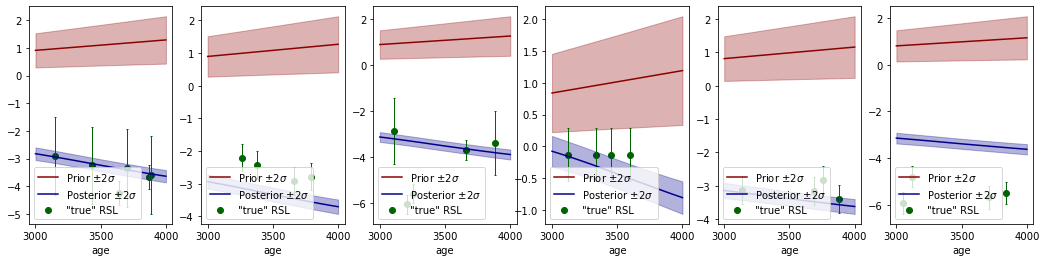

In [41]:

        def locs_with_enoughsamples(df_place, place, number):
            """make new dataframe, labeled, of sites with [> number] measurements"""
            df_lots = df_place.groupby(['lat',
                                        'lon']).filter(lambda x: len(x) > number)

            df_locs = []
            for i, group in enumerate(df_lots.groupby(['lat', 'lon'])):
                singleloc = group[1].copy()
                singleloc['location'] = place
                singleloc['locnum'] = place + '_site' + str(
                    i)  # + singleloc.reset_index().index.astype('str')
                df_locs.append(singleloc)
            df_locs = pd.concat(df_locs)

            return df_locs

        number = 3
        df_nufsamps = locs_with_enoughsamples(df_place, place, number)
        
#         try:
#             number = 8
#             df_nufsamps = locs_with_enoughsamples(df_place, place, number)
#         except:
# #             pass
#             try:
#                 number = 7
#                 df_nufsamps = locs_with_enoughsamples(df_place, place, number)
#             except: 
# #                 pass
#                 try:
#                     number = 6
#                     df_nufsamps = locs_with_enoughsamples(df_place, place, number)
#                 except:
# #                     pass
#                     try:
#                         number = 5
#                         df_nufsamps = locs_with_enoughsamples(df_place, place, number)
#                     except:
# #             pass
#                         try:
#                             number = 4
#                             df_nufsamps = locs_with_enoughsamples(df_place, place, number)
#                         except:
#                             pass
   
        

        print(len(df_nufsamps.locnum.unique()))

        
        ##################	PLOT LOCS W/NUF SAMPS   #######################
        ##################  --------------------	 ######################


        def slice_dataarray(da):
            return da.sel(lat=site[1].lat.unique(),
                          lon=site[1].lon.unique(),
                          method='nearest')


        fig, ax = plt.subplots(1, len(df_nufsamps.locnum.unique()), figsize=(18, 4))
        ax = ax.ravel()
        colors = ['darkgreen', 'darkblue', 'darkred']
        fontsize = 18

        for i, site in enumerate(df_nufsamps.groupby('locnum')):

            #slice data for each site
            prior_it = slice_dataarray(da_giapriorinterp)
            priorvar_it = slice_dataarray(da_giapriorinterpstd)
            top_prior = prior_it + priorvar_it * 2
            bottom_prior = prior_it - priorvar_it * 2

            var_it = slice_dataarray(np.sqrt(da_varp))
            post_it = slice_dataarray(da_priorplusgpr)
            top = post_it + var_it * 2
            bottom = post_it - var_it * 2

            site_err = 2 * (site[1].rsl_er_max)

            ax[i].scatter(site[1].age, site[1].rsl, c=colors[0], label='"true" RSL')
            ax[i].errorbar(
                site[1].age,
                site[1].rsl,
                site_err,
                c=colors[0],
                fmt='none',
                capsize=1,
                lw=1,
            )

            prior_it.plot(ax=ax[i], c=colors[2], label='Prior $\pm 2 \sigma$')
            ax[i].fill_between(prior_it.age,
                               bottom_prior.squeeze(),
                               top_prior.squeeze(),
                               color=colors[2],
                               alpha=0.3)

            post_it.plot(ax=ax[i], c=colors[1], label='Posterior $\pm 2 \sigma$')
            ax[i].fill_between(post_it.age,
                               bottom.squeeze(),
                               top.squeeze(),
                               color=colors[1],
                               alpha=0.3)
            #     ax[i].set_title(f'{site[0]} RSL', fontsize=fontsize)
            ax[i].set_title('')

            ax[i].legend(loc='lower left')

#         fig.savefig(dirName + f'{path_gen}_1Dfig',
#                     transparent=True)
#             plt.show()